In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stock = "KO"
data = yf.download(stock, start="2020-01-01", end="2025-12-31")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data_close = data["Close"]

In [4]:
price_ratio = data_close/data_close.shift(1)
returns = np.log(data_close/data_close.shift(1)).dropna()

### Why using logs for return?

#### Simple Returns (What You Actually Earn)

* When calculating actual profits/losses
* When computing portfolio values
* Easier to explain to non-technical people

#### Log Returns (Mathematical Convenience)

* Time-additivity: Returns over multiple periods sum nicely
* Symmetry: A 10% gain and 10% loss cancel out (-0.10536 + 0.09531 ≈ -0.01005)
* Better statistical properties for modeling

In [5]:
prices = [100, 110, 99, 108, 95]

# Both methods describe the same price changes:
simple_return = (110-100)/100    # 10% gain
log_return = np.log(110/100)     # 9.53% log gain

print(f"Simple return is {simple_return:.4f}")
print(f"Log return is {log_return:.4f}")

# From log return back to simple return:
print(f"{np.exp(log_return)-1:.4f}")

Simple return is 0.1000
Log return is 0.0953
0.1000


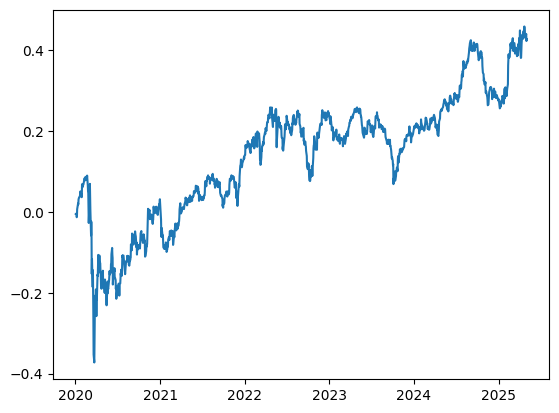

In [6]:
plt.plot(returns.cumsum())
#plt.plot(data_close)

In [7]:
trading_days = 252
annual_return = returns.mean() * trading_days
annual_volatility = returns.std() * np.sqrt(trading_days)

In [8]:
print(f"{stock} Annualized Return: {annual_return[stock]:.2%}")
print(f"{stock} Annualized Volatility: {annual_volatility[stock]:.2%}")

KO Annualized Return: 8.03%
KO Annualized Volatility: 20.95%


# Monte Carlo simulation

In [9]:
num_simulations = 10_000 
starting_price = data_close[-1:].values[0].item() # Last available price

In [10]:
daily_returns = np.random.normal(annual_return/trading_days, annual_volatility/np.sqrt(trading_days), (trading_days,num_simulations))
price_paths = starting_price * np.cumprod(1 + daily_returns, axis=0)

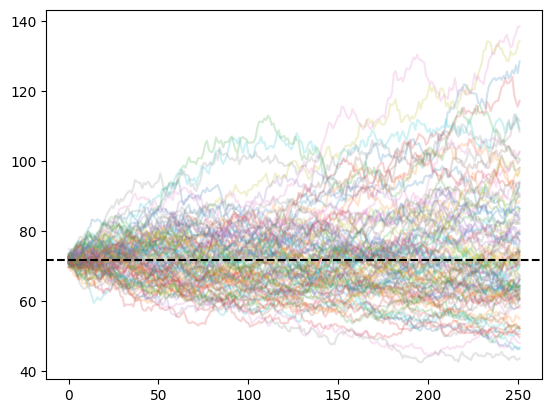

In [11]:
plt.plot(price_paths[:, :100], alpha=0.2)
plt.axhline(starting_price, color = 'black', linestyle = '--')

In [12]:
buckets_count = 30

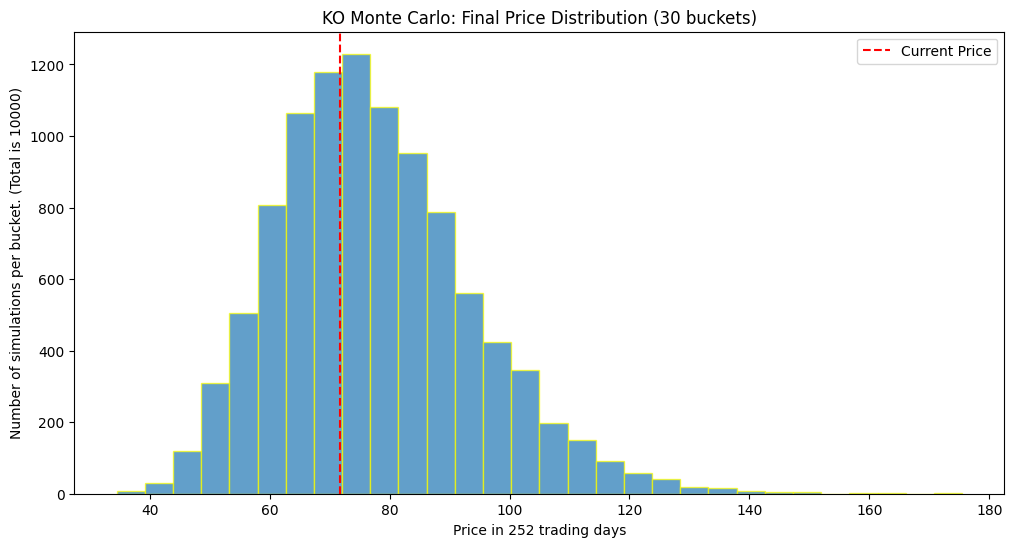

In [13]:
edges = buckets_count + 1
price_bins = np.linspace(np.min(price_paths), np.max(price_paths), edges)

plt.figure(figsize=(12,6))
plt.hist(price_paths[-1,:], bins=price_bins, edgecolor='yellow', alpha=0.7)
plt.axvline(starting_price, color='red', linestyle='--', label='Current Price')

plt.title(f"{stock} Monte Carlo: Final Price Distribution ({buckets_count} buckets)")
plt.xlabel(f"Price in {trading_days} trading days")
plt.ylabel(f"Number of simulations per bucket. (Total is {num_simulations})")

plt.legend()
plt.show()

### Calculate key risk metrics
* `loss_prob`: Counts simulations where final price < starting price
* `var_5`: 5th percentile = worst 5% of outcomes
* `Median/Q1/Q3`: Shows central tendency

In [14]:
loss_prob = (price_paths[-1] < starting_price).mean() * 100
var_5 = np.percentile(price_paths[-1], 5)
q1, median, q3 = np.percentile(price_paths[-1], [25,50, 75])

In [15]:
print(f"Probability of losing money: {loss_prob:.1f}%")
print(f"Worst 5% case: ${var_5:.2f} ({(var_5/starting_price-1):.0%} drop)")
print(f"Q1: ${q1:.2f} ({(q1/starting_price-1):.0%})")
print(f"Median outcome: ${median:.2f} ({(median/starting_price-1):.0%})")
print(f"Q3: ${q3:.2f} ({(q3/starting_price-1):.0%})")

Probability of losing money: 39.2%
Worst 5% case: $53.65 (-25% drop)
Q1: $65.89 (-8%)
Median outcome: $75.77 (6%)
Q3: $87.34 (22%)


In [16]:
data_close.tail()

Ticker,KO
Date,
2025-04-28,71.790001
2025-04-29,72.349998
2025-04-30,72.550003
2025-05-01,71.290001
2025-05-02,71.650002
